# Pandas Cython Snippet

In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.DataFrame({'a': np.random.randn(1000),
                   'b': np.random.randn(1000),
                   'N': np.random.randint(100, 1000, (1000)),
                   'x': 'x'})

In [4]:
df.head()

,a,b,N,x
0,0.627378,1.225315,168,x
1,-0.071675,-0.714634,955,x
2,0.695548,1.489496,844,x
3,-0.633328,-2.914657,221,x
4,-0.225063,1.457741,936,x


In [5]:
def f(x):
    return x*(x-1)

def integrate_f(a, b, N):
    s = 0
    dx = (b - a) / N
    for i in range(N):
        s += f(a + i * dx)
    return s * dx

In [28]:
%timeit df.apply(lambda x: integrate_f(x['a'], x['b'], x['N']), axis=1)

317 ms ± 77.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%prun -l 4 df.apply(lambda x: integrate_f(x['a'], x['b'], x['N']), axis=1)

In [10]:
%load_ext Cython

In [12]:
%%cython --annotate
cimport numpy as np # using Python library
import numpy as np
cdef double f_typed(double x) except? -2:
    return x * (x - 1)
cpdef double integrate_f_typed(double a, double b, int N):
    cdef int i
    cdef double s, dx
    s = 0
    dx = (b - a) / N
    for i in range(N):
        s += f_typed(a + i * dx)
    return s * dx
cpdef np.ndarray[double]  apply_integrate_f(np.ndarray col_a, np.ndarray col_b,
                                                                        np.ndarray col_N):
    assert (col_a.dtype == np.float and col_b.dtype == np.float and col_N.dtype == np.int)
    cdef Py_ssize_t i, n = len(col_N)
    assert (len(col_a) == len(col_b) == n)
    cdef np.ndarray[double] res = np.empty(n)
    for i in range(len(col_a)):
        res[i] = integrate_f_typed(col_a[i], col_b[i], col_N[i])
    return res

In [25]:
%timeit apply_integrate_f(df['a'].values, df['b'].values, df['N'].values)

2.05 ms ± 136 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
%prun -l 4 apply_integrate_f(df['a'].values, df['b'].values, df['N'].values)

In [23]:
# NUMBA JIT

import numba


@numba.jit
def f_plain(x):
    return x * (x - 1)


@numba.jit
def integrate_f_numba(a, b, N):
    s = 0
    dx = (b - a) / N
    for i in range(N):
        s += f_plain(a + i * dx)
    return s * dx


@numba.jit
def apply_integrate_f_numba(col_a, col_b, col_N):
    n = len(col_N)
    result = np.empty(n, dtype='float64')
    assert len(col_a) == len(col_b) == n
    for i in range(n):
        result[i] = integrate_f_numba(col_a[i], col_b[i], col_N[i])
    return result


def compute_numba(df):
    result = apply_integrate_f_numba(df['a'].values, df['b'].values,
                                     df['N'].values)
    return pd.Series(result, index=df.index, name='result')

In [27]:
%timeit compute_numba(df)

1.21 ms ± 89.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Cython
Cython can be viewed as an extension of Python where variables and functions are annotated with extra information, in particular types. The resulting Cython source code will be compiled into optimized C or C++ code, and thereby yielding substantial speed-up of slow Python code. In other words, Cython provides a way of writing Python with comparable performance to that of C/C++.

## Start Coding in Cython
Cython code must, unlike Python, be compiled. This happens in the following stages:

- The cython code in .pyx file will be translated to a C file.
- The C file will be compiled by a C compiler into a shared library, which will be directly loaded into Python.
- In a Jupyter notebook, everything is a lot easier. One needs only to load the Cython extension (%load_ext Cython) at the beginning and put %%cython mark in front of cells of Cython code. Cells with Cython mark will be treated as a .pyx code and consequently, compiled into C.

In [10]:
# Pure python Mandelbrot set:

xmin = -1.5
ymin = -1.0
xmax = 0.5
ymax = 1.0
resolution = 300
xstep = (xmax - xmin) / resolution
ystep = (ymax - ymin) / resolution
xs = [(xmin + (xmax - xmin) * i / resolution) for i in range(resolution)]
ys = [(ymin + (ymax - ymin) * i / resolution) for i in range(resolution)]

def mandel(position, limit=50):
    value = position
    while abs(value) < 2:
        limit -= 1
        value = value**2 + position
        if limit < 0:
            return 0
    return limit

In [17]:
%reload_ext Cython

In [18]:
%%cython

def mandel_cython(position, limit=50):
    value = position
    while abs(value) < 2:
        limit -= 1
        value = value**2 + position
        if limit < 0:
            return 0
    return limit

Text(0.5, 1.0, 'Cython')

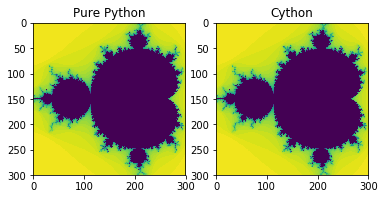

In [19]:
from matplotlib import pyplot as plt
%matplotlib inline
f, axarr = plt.subplots(1, 2)
axarr[0].imshow([[mandel(complex(x, y)) for x in xs] for y in ys], interpolation='none')
axarr[0].set_title('Pure Python')
axarr[1].imshow([[mandel_cython(complex(x, y)) for x in xs] for y in ys], interpolation='none')
axarr[1].set_title('Cython')

In [20]:
%timeit [[mandel(complex(x,y)) for x in xs] for y in ys] # pure python
%timeit [[mandel_cython(complex(x,y)) for x in xs] for y in ys] # cython

827 ms ± 43.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
542 ms ± 51.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Cython with C Types
But we can do better by telling Cython what C data type we would use in the code. Note we're not actually writing C, we're writing Python with C types.

In [21]:
%%cython

# Typed VAR
def var_typed_mandel_cython(position, limit=50):
    cdef double complex value
    value = position
    while abs(value) <= 2:
        limit -= 1
        value = value**2 + position
        if limit < 0:
            return 0
    return limit

In [22]:
%%cython

# Typed VAR + FUNC
cpdef call_typed_mandel_cython(double complex position,
                               int limit=50):
    cdef double complex value # typed variable
    value = position
    while abs(value)<2:
        limit -= 1
        value = value**2 + position
        if limit < 0:
            return 0
    return limit

In [23]:
# pure python
%timeit a = mandel(complex(0, 0)) 
# primitive cython
%timeit a = mandel_cython(complex(0, 0))
# cython with C type variable
%timeit a = var_typed_mandel_cython(complex(0, 0))
# cython with typed variable + function
%timeit a = call_typed_mandel_cython(complex(0, 0))

18.9 µs ± 701 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
10.2 µs ± 655 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
4.58 µs ± 90.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
849 ns ± 2.36 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


### Cython with numpy ndarray
You can use NumPy from Cython exactly the same as in regular Python, but by doing so you are losing potentially high speedups because Cython has support for fast access to NumPy arrays.

In [24]:
import numpy as np
ymatrix, xmatrix = np.mgrid[ymin:ymax:ystep, xmin:xmax:xstep]
values = xmatrix + 1j * ymatrix

In [25]:
%%cython
import numpy as np
cimport numpy as np 

cpdef numpy_cython_1(np.ndarray[double complex, ndim=2] position, 
                     int limit=50): 
    cdef np.ndarray[long,ndim=2] diverged_at
    cdef double complex value
    cdef int xlim
    cdef int ylim
    cdef double complex pos
    cdef int steps
    cdef int x, y

    xlim = position.shape[1]
    ylim = position.shape[0]
    diverged_at = np.zeros([ylim, xlim], dtype=int)
    for x in xrange(xlim):
        for y in xrange(ylim):
            steps = limit
            value = position[y,x]
            pos = position[y,x]
            while abs(value) < 2 and steps >= 0:
                steps -= 1
                value = value**2 + pos
            diverged_at[y,x] = steps
  
    return diverged_at

> Note the double import of numpy: the standard numpy module and a Cython-enabled version of numpy that ensures fast indexing of and other operations on arrays. Both import statements are necessary in code that uses numpy arrays. The new thing in the code above is declaration of arrays by np.ndarray.

In [26]:
%timeit data_cy = [[mandel(complex(x,y)) for x in xs] for y in ys] # pure python
%timeit data_cy = [[call_typed_mandel_cython(complex(x,y)) for x in xs] for y in ys] # typed cython

906 ms ± 31.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
53.1 ms ± 2.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [27]:
%timeit numpy_cython_1(values) # ndarray

21.8 ms ± 1.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


> A trick of using np.vectorize

In [28]:
numpy_cython_2 = np.vectorize(call_typed_mandel_cython)

In [29]:
%timeit numpy_cython_2(values) #  vectorize

29.5 ms ± 796 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Calling C functions from Cython

**Example: compare sin() from Python and C library**

In [30]:
%%cython
import math
cpdef py_sin():
    cdef int x
    cdef double y
    for x in range(1e7):
        y = math.sin(x)

In [31]:
%%cython
from libc.math cimport sin as csin # import from C library
cpdef c_sin():
    cdef int x
    cdef double y
    for x in range(1e7):
        y = csin(x)

In [32]:
%timeit [math.sin(i) for i in range(int(1e7))] # python
%timeit py_sin()                                # cython call python library
%timeit c_sin()                                 # cython call C library

2.99 s ± 217 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.82 s ± 389 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
9.42 ms ± 1.25 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


# CYMEM - Cython Memory Pool for RAII-style memory management

> Tying memory to Python object life-cycle, freed upon garbage collection

- Pool object saves MEM_ADDR internally, freeing them upon object GC
- Typically attached Pool to some `cdef` class
- Handy for deeply nested STRUCT having complex INIT func
    - Just pass Pool object to INIT and worry-free about freeing STRUCT MEM
    - All calls to Pool.alloc auto-freed upon Pool expiration

In [25]:
pip install git+https://github.com/cython/cython.git

  Cloning https://github.com/cython/cython.git to /private/var/folders/tl/7g0s_v3s2nx8fqg_nh1b1zgr0000gn/T/pip-req-build-k68bl83a
  Stored in directory: /private/var/folders/tl/7g0s_v3s2nx8fqg_nh1b1zgr0000gn/T/pip-ephem-wheel-cache-ogwe0ntk/wheels/3d/f7/30/9fc0c15f3a2890d83a1e1398b568efa31a55ef3098f997dd28
Successfully built Cython
  Found existing installation: Cython 0.29.6
    Uninstalling Cython-0.29.6:
      Successfully uninstalled Cython-0.29.6
Note: you may need to restart the kernel to use updated packages.


In [14]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


### Example: Array of Structs

- Sparse matrices with fast access, need C-array or C++Vector

In [34]:
%%cython

"""Example without Cymem

To use an array of structs, we must carefully walk the data structure when
we deallocate it.
"""


from libc.stdlib cimport calloc, free

cdef struct SparseRow:
    size_t length
    size_t* indices
    double* values

cdef struct SparseMatrix:
    size_t length
    SparseRow* rows

cdef class MatrixArray:
    cdef size_t length
    cdef SparseMatrix** matrices

    def __cinit__(self, list py_matrices):
        self.length = 0
        self.matrices = NULL

    def __init__(self, list py_matrices):
        self.length = len(py_matrices)
        self.matrices = <SparseMatrix**>calloc(len(py_matrices), sizeof(SparseMatrix*))

        for i, py_matrix in enumerate(py_matrices):
            self.matrices[i] = sparse_matrix_init(py_matrix)

    def __dealloc__(self):
        for i in range(self.length):
            sparse_matrix_free(self.matrices[i])
        free(self.matrices)


cdef SparseMatrix* sparse_matrix_init(list py_matrix) except NULL:
    sm = <SparseMatrix*>calloc(1, sizeof(SparseMatrix))
    sm.length = len(py_matrix)
    sm.rows = <SparseRow*>calloc(sm.length, sizeof(SparseRow))
    cdef size_t i, j
    cdef dict py_row
    cdef size_t idx
    cdef double value
    for i, py_row in enumerate(py_matrix):
        sm.rows[i].length = len(py_row)
        sm.rows[i].indices = <size_t*>calloc(sm.rows[i].length, sizeof(size_t))
        sm.rows[i].values = <double*>calloc(sm.rows[i].length, sizeof(double))
        for j, (idx, value) in enumerate(py_row.items()):
            sm.rows[i].indices[j] = idx
            sm.rows[i].values[j] = value
    return sm


cdef void* sparse_matrix_free(SparseMatrix* sm) except *:
    cdef size_t i
    for i in range(sm.length):
        free(sm.rows[i].indices)
        free(sm.rows[i].values)
    free(sm.rows)
    free(sm)

We wrap the data structure in a Python ref-counted class at as low a level as we can, given our performance constraints. This allows us to allocate and free the memory in the __cinit__ and __dealloc__ Cython special methods.

However, it's very easy to make mistakes when writing the __dealloc__ and sparse_matrix_free functions, leading to memory leaks. cymem prevents you from writing these deallocators at all. Instead, you write as follows:



In [35]:
%%cython

"""Example with Cymem.

Memory allocation is hidden behind the Pool class, which remembers the
addresses it gives out.  When the Pool object is garbage collected, all of
its addresses are freed.

We don't need to write MatrixArray.__dealloc__ or sparse_matrix_free,
eliminating a common class of bugs.
"""

from cymem.cymem cimport Pool

cdef struct SparseRow:
    size_t length
    size_t* indices
    double* values

cdef struct SparseMatrix:
    size_t length
    SparseRow* rows


cdef class MatrixArray:
    cdef size_t length
    cdef SparseMatrix** matrices
    cdef Pool mem

    def __cinit__(self, list py_matrices):
        self.mem = None
        self.length = 0
        self.matrices = NULL

    def __init__(self, list py_matrices):
        self.mem = Pool()
        self.length = len(py_matrices)
        self.matrices = <SparseMatrix**>self.mem.alloc(self.length, sizeof(SparseMatrix*))
        for i, py_matrix in enumerate(py_matrices):
            self.matrices[i] = sparse_matrix_init(self.mem, py_matrix)

cdef SparseMatrix* sparse_matrix_init_cymem(Pool mem, list py_matrix) except NULL:
    sm = <SparseMatrix*>mem.alloc(1, sizeof(SparseMatrix))
    sm.length = len(py_matrix)
    sm.rows = <SparseRow*>mem.alloc(sm.length, sizeof(SparseRow))
    cdef size_t i, j
    cdef dict py_row
    cdef size_t idx
    cdef double value
    for i, py_row in enumerate(py_matrix):
        sm.rows[i].length = len(py_row)
        sm.rows[i].indices = <size_t*>mem.alloc(sm.rows[i].length, sizeof(size_t))
        sm.rows[i].values = <double*>mem.alloc(sm.rows[i].length, sizeof(double))
        for j, (idx, value) in enumerate(py_row.items()):
            sm.rows[i].indices[j] = idx
            sm.rows[i].values[j] = value
    return sm


Error compiling Cython file:
------------------------------------------------------------
...
    def __init__(self, list py_matrices):
        self.mem = Pool()
        self.length = len(py_matrices)
        self.matrices = <SparseMatrix**>self.mem.alloc(self.length, sizeof(SparseMatrix*))
        for i, py_matrix in enumerate(py_matrices):
            self.matrices[i] = sparse_matrix_init(self.mem, py_matrix)
                              ^
------------------------------------------------------------

/Users/Ocean/.ipython/cython/_cython_magic_1a39fe49ed61055ba4c0de375b8d1feb1d03553f.pyx:39:31: undeclared name not builtin: sparse_matrix_init

Error compiling Cython file:
------------------------------------------------------------
...
    def __init__(self, list py_matrices):
        self.mem = Pool()
        self.length = len(py_matrices)
        self.matrices = <SparseMatrix**>self.mem.alloc(self.length, sizeof(SparseMatrix*))
        for i, py_matrix in enumerate(py_matrices):
  

TypeError: object of type 'NoneType' has no len()